# Joint Intent Classification and Slot Filling with Transformers

The goal of this notebook is to fine-tune a pretrained transformer-based neural network model to convert a user query expressed in English into
a representation that is structured enough to be processed by an automated service.

Here is an example of interpretation computed by such a Natural Language Understanding system:

```python
>>> nlu("Book a table for two at Le Ritz for Friday night",
        tokenizer, joint_model, intent_names, slot_names)
```
```
{
    'intent': 'BookRestaurant',
    'slots': {
        'party_size_number': 'two',
        'restaurant_name': 'Le Ritz',
        'timeRange': 'Friday night'
    }
}
```

Intent classification is a simple sequence classification problem. The trick is to treat the structured knowledge extraction part ("Slot Filling") as token-level classification problem using BIO-annotations:

```python
>>> show_predictions("Book a table for two at Le Ritz for Friday night!",
...                  tokenizer, joint_model, intent_names, slot_names)
```
```
## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

We will show how to train a such as join "sequence classification" and "token classification" joint model on a [voice command dataset]() published by snips.ai.


This notebook is a partial reproduction of some of the results presented in this paper:

BERT for Joint Intent Classification and Slot Filling
Qian Chen, Zhu Zhuo, Wen Wang

https://arxiv.org/abs/1902.10909

In [1]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [2]:
!nvidia-smi

Mon Oct  2 08:17:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: update this notebook to work with the latest version of transformers
%pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00


## The Data

We will use a speech command dataset collected, annotated and published by French startup SNIPS.ai (bought in 2019 by Audio device manufacturer Sonos).

The original dataset comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html).

Instead we will use a preprocessed variant with token level B-I-O annotations closer the representation our model will predict. This variant of the SNIPS
dataset was prepared by [Su Zhu](https://github.com/sz128).



In [4]:
from urllib.request import urlretrieve
from pathlib import Path


SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)
for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
    path = Path(filename)
    if not path.exists():
        print(f"Downloading {filename}...")
        urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

Let's have a look at the first lines from the training set:

In [5]:
lines_train = Path("train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist',
 'put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist',
 'add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist',
 'add:O this:O artist:B-music_item to:O my:B-playlist_owner this:B-playlist is:I-playlist miguel:I-playlist bosé:I-playlist playlist:O <=> AddToPlaylist',
 'add:O heresy:B-entity_name and:I-entity_name the:I-entity_name hotel:I-entity_name choir:I-entity_name to:O the:O evening:B-playlist acoustic:I-playlist playlist:O <=> AddToPlaylist']

In [6]:
len(lines_train)

13084

Some remarks:

- The class label for the voice command appears at the end of each line (after the "<=>" marker).
- Each word-level token is annotated with B-I-O labels using the ":" separator.
- B/I/O stand for "Beginning" / "Inside" / "Outside"
- "Add:O" means that the token "Add" is "Outside" of any annotation span
- "Don:B-entity_name" means that "Don" is the "Beginning" of an annotation of type "entity-name".
- "and:I-entity_name" means that "and" is "Inside" the previously started annotation of type "entity-name".


Let's write a parsing function and test it on the first line:

In [7]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

In [8]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'word_labels': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

This utterance is a voice command of type "AddToPlaylist" with to annotations:

- an entity-name: "Don and Sherri",
- a playlist: "Medidate to Sounds of Nature".


The goal of this project is to build a baseline Natural Understanding model to analyse such voice commands and predict:

- the intent of the speaker: the sentence level class label ("AddToPlaylist");
- extract the interesting "slots" (typed named entities) from the sentence by performing word level classification using the B-I-O tags as target classes. This second task is often referred to as "NER" (Named Entity Recognition) in the Natural Language Processing literature. Alternatively this is also known as "slot filling" when we expect a fixed set of named entity per sentence of a given class.

The list of possible classes for the sentence level and the word level classification problems are given as:




In [9]:
print(Path("vocab.intent").read_text("utf-8"))

AddToPlaylist
BookRestaurant
GetWeather
PlayMusic
RateBook
SearchCreativeWork
SearchScreeningEvent



In [10]:
print(Path("vocab.slot").read_text("utf-8"))

B-album
B-artist
B-best_rating
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-facility
B-genre
B-geographic_poi
B-location_name
B-movie_name
B-movie_type
B-music_item
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-playlist
B-playlist_owner
B-poi
B-rating_unit
B-rating_value
B-restaurant_name
B-restaurant_type
B-served_dish
B-service
B-sort
B-spatial_relation
B-state
B-timeRange
B-track
B-year
I-album
I-artist
I-city
I-country
I-cuisine
I-current_location
I-entity_name
I-facility
I-genre
I-geographic_poi
I-location_name
I-movie_name
I-movie_type
I-music_item
I-object_location_type
I-object_name
I-object_part_of_series_type
I-object_select
I-object_type
I-party_size_description
I-playlist
I-playlist_owner
I-poi
I-restaurant_name
I-restaurant_type
I-served_dish
I-service
I-sort
I-spatial_relation
I-state
I-timeRange
I-track
O



"POI" stands for "Point of Interest".

Let's parse all the lines and store the results in pandas DataFrames:

In [11]:
import pandas as pd

parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [12]:
df_train.groupby("intent_label").count()

,words,word_labels,length
intent_label,,,
AddToPlaylist,1842,1842,1842
BookRestaurant,1873,1873,1873
GetWeather,1900,1900,1900
PlayMusic,1900,1900,1900
RateBook,1856,1856,1856
SearchCreativeWork,1854,1854,1854
SearchScreeningEvent,1859,1859,1859


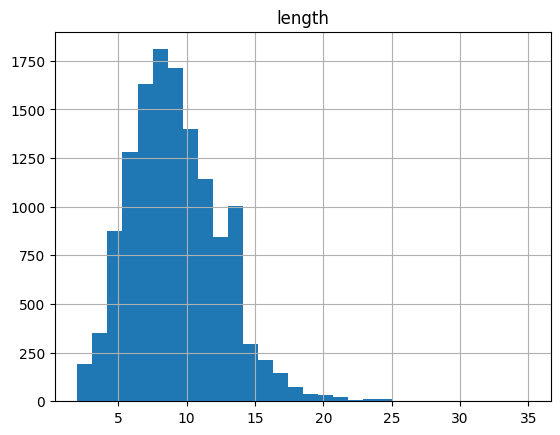

In [13]:
df_train.hist("length", bins=30);

In [14]:
lines_valid = Path("valid").read_text("utf-8").strip().splitlines()
lines_test = Path("test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])


## A First Model: Intent Classification (Sentence Level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both TF2/Keras and Pytorch APIs.

### The BERT Tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set:

In [15]:
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [16]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'Add Don and Sherri to my Meditate to Sounds of Nature playlist'

In [17]:
tokenizer.tokenize(first_sentence)

['Ad',
 '##d',
 'Don',
 'and',
 'She',
 '##rri',
 'to',
 'my',
 'Me',
 '##dit',
 '##ate',
 'to',
 'Sounds',
 'of',
 'Nature',
 'play',
 '##list']

Notice that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.

**Question**:

- why is it particulary interesting to use subword tokenization for general purpose language models such as BERT?


Each token string is mapped to a unique integer id that makes it fast to lookup the right column in the input layer token embedding:

In [18]:
tokenizer.encode(first_sentence)

[101,
 24930,
 1181,
 1790,
 1105,
 1153,
 14791,
 1106,
 1139,
 2508,
 17903,
 2193,
 1106,
 10560,
 1104,
 7009,
 1505,
 7276,
 102]

In [19]:
tokenizer.decode(tokenizer.encode(first_sentence))

'[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]'

Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).
- Here we want to use BERT to compute a representation of a single voice command at a time
- We could reuse the representation of the `[CLS]` token for sequence classification.
- Alternatively we can pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.

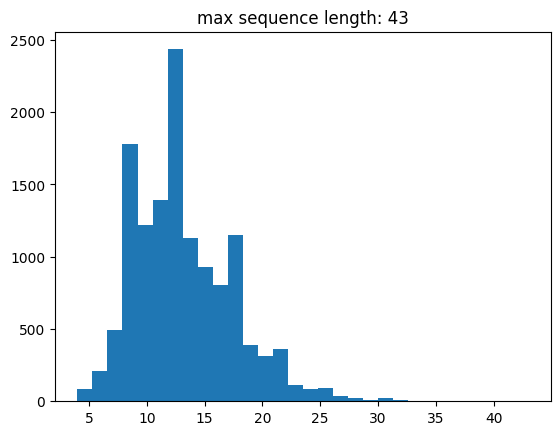

In [20]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

To perform transfer learning, we will need to work with padded sequences so they all have the same sizes. The above histograms, shows that after tokenization, 43 tokens are enough to represent all the voice commands in the training set.

The mapping can be introspected in the `tokenizer.vocab` attribute:

In [21]:
tokenizer.vocab_size

28996

In [22]:
bert_vocab_items = list(tokenizer.vocab.items())
bert_vocab_items[:10]

[('[PAD]', 0),
 ('[unused1]', 1),
 ('[unused2]', 2),
 ('[unused3]', 3),
 ('[unused4]', 4),
 ('[unused5]', 5),
 ('[unused6]', 6),
 ('[unused7]', 7),
 ('[unused8]', 8),
 ('[unused9]', 9)]

In [23]:
bert_vocab_items[100:110]

[('[UNK]', 100),
 ('[CLS]', 101),
 ('[SEP]', 102),
 ('[MASK]', 103),
 ('[unused100]', 104),
 ('[unused101]', 105),
 ('!', 106),
 ('"', 107),
 ('#', 108),
 ('$', 109)]

In [24]:
bert_vocab_items[900:910]

[('く', 900),
 ('け', 901),
 ('こ', 902),
 ('さ', 903),
 ('し', 904),
 ('す', 905),
 ('せ', 906),
 ('そ', 907),
 ('た', 908),
 ('ち', 909)]

In [ ]:
bert_vocab_items[1100:1110]

[('－', 1100),
 ('／', 1101),
 ('：', 1102),
 ('the', 1103),
 ('of', 1104),
 ('and', 1105),
 ('to', 1106),
 ('in', 1107),
 ('was', 1108),
 ('The', 1109)]

In [ ]:
bert_vocab_items[20000:20010]

[('attested', 20000),
 ('Hillary', 20001),
 ('##DM', 20002),
 ('gal', 20003),
 ('wander', 20004),
 ('Salle', 20005),
 ('##laming', 20006),
 ('Perez', 20007),
 ('Pit', 20008),
 ('##LP', 20009)]

In [ ]:
bert_vocab_items[-10:]

[('##한', 28986),
 ('##ﬁ', 28987),
 ('##ﬂ', 28988),
 ('##！', 28989),
 ('##（', 28990),
 ('##）', 28991),
 ('##，', 28992),
 ('##－', 28993),
 ('##／', 28994),
 ('##：', 28995)]

Couple of remarks:

- 30K is a reasonable vocabulary size and is small enough to be used in a softmax output layer;
- it can represent multi-lingual sentences, including non-Western alphabets;
- subword tokenization makes it possible to deal with typos and morphological variations with a small vocabulary side and without any language-specific preprocessing;
- subword tokenization makes it unlikely to use the `[UNK]` special token as rare words can often be represented as a sequence of frequent enough short subwords in a meaningful way.

### Encoding the Dataset with the Tokenizer

Let's now encode the full train / valid and test sets with our tokenizer to get a padded integer numpy arrays:

In [25]:
import numpy as np


def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}  # TODO: Change to mask


encoded_train = encode_dataset(tokenizer, df_train["words"], 45)
encoded_train["input_ids"]

array([[  101, 24930,  1181, ...,     0,     0,     0],
       [  101,  1508,  1244, ...,     0,     0,     0],
       [  101,  5194,  1103, ...,     0,     0,     0],
       ...,
       [  101, 27640,  1116, ...,     0,     0,     0],
       [  101,  5979,  6608, ...,     0,     0,     0],
       [  101,  1327,  2523, ...,     0,     0,     0]], dtype=int32)

In [26]:
encoded_train["attention_masks"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [27]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 45)
encoded_test = encode_dataset(tokenizer, df_test["words"], 45)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [28]:
intent_names = Path("vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [29]:
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([0, 0, 0, ..., 6, 6, 6])

In [30]:
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained BERT model

Let's load a pretrained BERT model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [31]:
from transformers import TFAutoModel

base_bert_model = TFAutoModel.from_pretrained("bert-base-cased")
base_bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
encoded_valid['attention_mask'] = encoded_valid.pop('attention_masks')
encoded_valid

{'input_ids': array([[  101,   142, 13894, ...,     0,     0,     0],
        [  101,  2825,   179, ...,     0,     0,     0],
        [  101, 24930,  1181, ...,     0,     0,     0],
        ...,
        [  101,  1525,   170, ...,     0,     0,     0],
        [  101,  4630,  1143, ...,     0,     0,     0],
        [  101,  1327,  1159, ...,     0,     0,     0]], dtype=int32),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)}

In [33]:
outputs = base_bert_model(encoded_valid)
len(outputs)

2

The **first ouput** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [34]:
outputs[0].shape

TensorShape([700, 45, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**. This is will be used as the features of our Intent classifier:

In [35]:
outputs[1].shape

TensorShape([700, 768])

### Exercise

Use the following code template to build and train a **sequence classification model** using to predict the **intent class**.

Use the `self.bert` pre-trained model in the `call` method and only consider the pooled features (ignore the token-wise features for now).

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        # Let's preload the pretrained model BERT in the constructor of our
        # classifier model
        self.bert = TFAutoModel.from_pretrained(model_name)

        # TODO: define a (Dense) classification layer to compute the
        # for each sequence in a batch the batch of samples. The number of
        # output classes is given by the intent_num_labels parameter.

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.

    def call(self, inputs, training=False):
        # Use the pretrained model to extract features from our encoded inputs:
        sequence_output, pooled_output = self.bert(inputs, training=training)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.

        # TODO: use the classifier layer to compute the logits from the pooled
        # features.
        intent_logits = None
        return intent_logits


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

# TODO: uncomment to train the model:

# history = intent_model.fit(encoded_train, intent_train, epochs=2, batch_size=32,
#                            validation_data=(encoded_valid, intent_valid))

### Solution

In [36]:
import tensorflow as tf
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


class IntentClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="bert-base-cased",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.
        self.intent_classifier = Dense(intent_num_labels)

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        # sequence_output, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        # print(outputs)
        pooled_output = self.dropout(outputs['pooler_output'], training=training)

        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Our classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is included in the loss function instead of the model directly.

We need to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly:

In [37]:
intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

In [38]:
if 'attention_masks' in encoded_train.keys():
  encoded_train['attention_mask'] = encoded_train.pop('attention_masks')

In [39]:
history = intent_model.fit(encoded_train, intent_train, epochs=2, batch_size=32,
                           validation_data=(encoded_valid, intent_valid))

Epoch 1/2
409/409 [==============================] - 181s 318ms/step - loss: 0.1617 - accuracy: 0.9493 - val_loss: 0.0435 - val_accuracy: 0.9871
Epoch 2/2
409/409 [==============================] - 122s 299ms/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0393 - val_accuracy: 0.9929


In [40]:
def classify(text, tokenizer, model, intent_names):
    inputs = tf.constant(tokenizer.encode(text))  # batch_size = 1

    token_ids = np.zeros(shape=(1, 45),
                         dtype=np.int32)
    token_ids[0, 0:len(inputs)] = inputs
    attention_mask = (token_ids != 0).astype(np.int32)
    inputs = {"input_ids": token_ids, "attention_mask": attention_mask}

    class_id = model(inputs).numpy().argmax(axis=1)[0]

    return intent_names[class_id]


classify("Book a table for two at La Tour d'Argent for Friday night.",
         tokenizer, intent_model, intent_names)

'BookRestaurant'

In [41]:
classify("I would like to listen to Anima by Thom Yorke.",
         tokenizer, intent_model, intent_names)

'PlayMusic'

In [42]:
classify("Will it snow tomorrow in Saclay?",
         tokenizer, intent_model, intent_names)

'GetWeather'

In [43]:
classify("Where can I see to the last Star Wars near Odéon tonight?",
         tokenizer, intent_model, intent_names)

'SearchScreeningEvent'

## Join Intent Classification and Slot Filling

Let's now refine our Natural Language Understanding system by trying the retrieve the important structured elements of each voici command.

To do so we will perform word level (or token level) classification of the BIO labels.

Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens.


Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens:

In [44]:
slot_names = ["[PAD]"]
slot_names += Path("vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'B-album': 1,
 'B-artist': 2,
 'B-best_rating': 3,
 'B-city': 4,
 'B-condition_description': 5,
 'B-condition_temperature': 6,
 'B-country': 7,
 'B-cuisine': 8,
 'B-current_location': 9,
 'B-entity_name': 10,
 'B-facility': 11,
 'B-genre': 12,
 'B-geographic_poi': 13,
 'B-location_name': 14,
 'B-movie_name': 15,
 'B-movie_type': 16,
 'B-music_item': 17,
 'B-object_location_type': 18,
 'B-object_name': 19,
 'B-object_part_of_series_type': 20,
 'B-object_select': 21,
 'B-object_type': 22,
 'B-party_size_description': 23,
 'B-party_size_number': 24,
 'B-playlist': 25,
 'B-playlist_owner': 26,
 'B-poi': 27,
 'B-rating_unit': 28,
 'B-rating_value': 29,
 'B-restaurant_name': 30,
 'B-restaurant_type': 31,
 'B-served_dish': 32,
 'B-service': 33,
 'B-sort': 34,
 'B-spatial_relation': 35,
 'B-state': 36,
 'B-timeRange': 37,
 'B-track': 38,
 'B-year': 39,
 'I-album': 40,
 'I-artist': 41,
 'I-city': 42,
 'I-country': 43,
 'I-cuisine': 44,
 'I-current_location': 45,
 'I-entity_name': 

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [45]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded


slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 45)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 45)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, 45)

In [46]:
slot_train[0]

array([ 0, 72, 72, 10, 46, 46, 46, 72, 26, 25, 60, 60, 60, 60, 60, 60, 72,
       72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [47]:
slot_valid[0]

array([ 0,  2, 41, 41, 72, 72, 72, 26, 25, 72, 72,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

### Exercise

Use the following code template to build a joint sequence and token classification model suitable for training on our encoded dataset with slot labels:



In [49]:
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense


class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        # TODO: define all the needed layers here.

    def call(self, inputs, training=False):
        # TODO: extract the features from the inputs using the pre-trained
        # BERT model here.

        # TODO: use the new layers to predict slot class (logits) for each
        # token position in the input sequence:
        slot_logits = None  # (batch_size, seq_len, slot_num_labels)

        # TODO: define a second classification head for the sequence-wise
        # predictions:
        intent_logits = None  # (batch_size, intent_num_labels)

        return slot_logits, intent_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

# Define one classification loss for each output:
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
joint_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                    loss=losses)

# TODO: uncomment to train the model:
# history = joint_model.fit(
#     encoded_train, (slot_train, intent_train),
#     validation_data=(encoded_valid, (slot_valid, intent_valid)),
#     epochs=2, batch_size=32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w








### Solution:


In [53]:
from transformers import TFAutoModel
from tensorflow.keras.layers import Dropout, Dense


class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, training=False):
        outputs = self.bert(inputs, training=training, output_hidden_states=True) # , return_dict=False)
        sequence_output, pooled_output = outputs['last_hidden_state'], outputs['pooler_output']  # TODO: Where do I get sequence output from?

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=training)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [55]:
history = joint_model.fit(
    encoded_train, (slot_train, intent_train),
    validation_data=(encoded_valid, (slot_valid, intent_valid)),
    epochs=2, batch_size=32)

Epoch 1/2
409/409 [==============================] - 187s 323ms/step - loss: 0.4687 - output_1_loss: 0.2963 - output_2_loss: 0.1724 - output_1_accuracy: 0.9367 - output_2_accuracy: 0.9478 - val_loss: 0.0851 - val_output_1_loss: 0.0380 - val_output_2_loss: 0.0471 - val_output_1_accuracy: 0.9897 - val_output_2_accuracy: 0.9886
Epoch 2/2
409/409 [==============================] - 127s 310ms/step - loss: 0.0727 - output_1_loss: 0.0404 - output_2_loss: 0.0323 - output_1_accuracy: 0.9893 - output_2_accuracy: 0.9903 - val_loss: 0.0781 - val_output_1_loss: 0.0251 - val_output_2_loss: 0.0530 - val_output_1_accuracy: 0.9930 - val_output_2_accuracy: 0.9871


The following function uses our trained model to make a prediction on a single text sequence and display both the sequence-wise and the token-wise class labels:

In [56]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

In [57]:
show_predictions("Book a table for two at Le Ritz for Friday night!",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O


In [58]:
show_predictions("Will it snow tomorrow in Saclay?",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: GetWeather
## Slots:
      Will : O
        it : O
      snow : B-condition_description
  tomorrow : B-timeRange
        in : O
        Sa : B-city
       ##c : I-city
     ##lay : I-city
         ? : O


In [59]:
show_predictions("I would like to listen to Anima by Thom Yorke.",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: SearchCreativeWork
## Slots:
         I : O
     would : O
      like : O
        to : O
    listen : O
        to : O
        An : B-object_name
     ##ima : I-object_name
        by : O
      Thom : B-artist
      York : I-artist
       ##e : I-artist
         . : O


### Decoding Predictions into Structured Knowledge

For completeness, here a minimal function to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries:

In [60]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [61]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

nlu("Book a table for two at Le Ritz for Friday night",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'BookRestaurant',
 'slots': {'party_size_number': 'two',
  'restaurant_name': 'Le Ritz',
  'timeRange': 'Friday night'}}

In [62]:
nlu("Will it snow tomorrow in Saclay",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'GetWeather',
 'slots': {'condition_description': 'snow',
  'timeRange': 'tomorrow',
  'city': 'Saclay'}}

In [63]:
nlu("I would like to listen to Anima by Thom Yorke",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'SearchCreativeWork',
 'slots': {'object_name': 'Anima', 'artist': 'Thom Yorke'}}

## Limitations

### Language

BERT is pretrained primarily on English content. It can therefore only extract meaningful features on text written in English.

Note that there exists alternative pretrained model that use a mix of different languages (e.g. [XLM](https://github.com/facebookresearch/XLM/)) and others that have been trained on other languages. For instance [CamemBERT](https://camembert-model.fr/) is pretrained on French text. Both kinds of models are available in the transformers package:

https://github.com/huggingface/transformers#model-architectures

The public snips.ai dataset used for fine-tuning is English only. To build a model for another language we would need to collect and annotate a similar corpus with tens of thousands of diverse, representative samples.


### Biases Embedded in the Pre-Trained Model

The original data used to pre-trained BERT was collected from the Internet and contains all kinds of data, including offensive and hateful speech.

While using BERT for or voice command understanding system is quite unlikely to be significantly impacted by those biases, it could be a serious problem for other kinds of applications such as Machine Translation for instance.

It is therefore strongly recommended to spend time auditing the biases that are embedded in such pre-trained models before deciding to deploy system that derive from them.

### Computational Resources

The original BERT model has many parameters which uses a lot of memory and can be prohibitive to deploy on small devices such as mobile phones. It is also very computationally intensive and typically requires powerful GPUs or TPUs to process text data at a reasonable speed (both for training and at inference time).

Designing alternative architectures with fewer parameters or more efficient training and inference procedures is still a very active area of research.

Depending of on the problems, it might be the case that simpler architectures based on convolutional neural networks and LSTMs might offer a better speed / accuracy trade-off.
